In [1]:
pip install pandas numpy networkx scikit-learn scip

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of ome-zarr to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of anndata to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of anndata to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See

In [2]:
import os
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import ttest_rel, wilcoxon, f_oneway

In [3]:
TRUST_PATH = "filmtrust_data/trust.txt" 
OUTPUT_DIR = "outputs_filmtrust"
os.makedirs(OUTPUT_DIR, exist_ok=True)

W_VALUES = [0.6, 0.7, 0.8, 0.9]
EPS = 1e-15

In [6]:
import os

# 1. Print current working directory
print("Current Directory:", os.getcwd())

# 2. List files in the current directory to see if 'filmtrust_data' is there
print("Files in directory:", os.listdir('.'))

# 3. Check if the specific path exists
print("Path exists?", os.path.exists('filmtrust_data/trust.txt'))

Current Directory: /workspaces/ft_
Files in directory: ['outputs_filmtrust', '.git', 'ft.ipynb', '\xa0filmtrust_data', 'README.md', 'film-trust.zip']
Path exists? False


In [7]:
import os
os.rename('\xa0filmtrust_data', 'filmtrust_data')

In [8]:
import zipfile

with zipfile.ZipFile('film-trust.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [9]:
TRUST_PATH = 'filmtrust_data/trust.txt'
import os
print("Path exists now?", os.path.exists(TRUST_PATH))

Path exists now? True


In [10]:
import pandas as pd
import os

# 1. FIX: Rename the folder to remove the hidden non-breaking space if it exists
try:
    if os.path.exists('\xa0filmtrust_data'):
        os.rename('\xa0filmtrust_data', 'filmtrust_data')
        print("[FIX] Renamed folder to remove hidden characters.")
except Exception as e:
    pass

# 2. Define the Path
TRUST_PATH = 'filmtrust_data/trust.txt'

def load_filmtrust(path):
    """
    Loads the FilmTrust dataset.
    Format: [TrusterID] [TrusteeID] [Value]
    """
    # Using sep='\s+' handles spaces or tabs automatically
    df = pd.read_csv(path, sep='\s+', header=None, names=["u", "v", "label"])
    
    # Standardizing labels to binary: 1 if trust >= 1, else 0
    df['label'] = (df['label'] >= 1).astype(int)
    return df

# 3. Execution
if os.path.exists(TRUST_PATH):
    df = load_filmtrust(TRUST_PATH)
    y = df.label.values
    
    print(f"[OK] Loaded FilmTrust | edges: {len(df)}")
    print("\n--- Data Preview ---")
    print(df.head())
    print("\nLabel Distribution (0 = Distrust, 1 = Trust):")
    print(df['label'].value_counts())
else:
    print(f"[ERROR] File not found at: {TRUST_PATH}")
    print("Check if the folder 'filmtrust_data' exists in your current directory.")
    

[OK] Loaded FilmTrust | edges: 1853

--- Data Preview ---
   u     v  label
0  2   966      1
1  2   104      1
2  5  1509      1
3  6  1192      1
4  7  1510      1

Label Distribution (0 = Distrust, 1 = Trust):
label
1    1853
Name: count, dtype: int64


<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_6869/3082880394.py:21: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(path, sep='\s+', header=None, names=["u", "v", "label"])


In [11]:
G = nx.DiGraph()
for _, r in df.iterrows():
    G.add_edge(r.u, r.v)
UG = G.to_undirected()

In [12]:
rows = []
for _, r in df.iterrows():
    # Connectivity features
    cn = len(list(nx.common_neighbors(UG, r.u, r.v))) if UG.has_node(r.u) and UG.has_node(r.v) else 0
    
    try:
        jaccard = next(nx.jaccard_coefficient(UG, [(r.u, r.v)]))[2]
        adamic = next(nx.adamic_adar_index(UG, [(r.u, r.v)]))[2]
    except (nx.NetworkXError, StopIteration):
        jaccard, adamic = 0, 0

    rows.append({
        "u": r.u, "v": r.v, "label": r.label,
        "u_in": G.in_degree(r.u), "u_out": G.out_degree(r.u),
        "v_in": G.in_degree(r.v), "v_out": G.out_degree(r.v),
        "cn": cn, "jaccard": jaccard, "adamic": adamic,
        "pa": G.degree(r.u) * G.degree(r.v)
    })

feature_df = pd.DataFrame(rows).fillna(0)

In [13]:
node_cols = ["u_in", "u_out", "v_in", "v_out"]
link_cols = ["jaccard", "adamic", "pa", "cn"]

# Scaling
for c in node_cols:
    feature_df[c] = np.log1p(feature_df[c])
feature_df[node_cols] = StandardScaler().fit_transform(feature_df[node_cols])

feature_df["pa"] = np.log1p(feature_df["pa"])
feature_df[link_cols] = MinMaxScaler().fit_transform(feature_df[link_cols])

X = feature_df[node_cols + link_cols]

# Reliability logic
if len(np.unique(y)) > 1:
    auc_scores = {c: roc_auc_score(y, X[c]) for c in X.columns}
    mi_vals = mutual_info_classif(X, y, random_state=0)
else:
    # If FilmTrust only has positive trust, we use default weights
    auc_scores = {c: 1.0 for c in X.columns}
    mi_vals = np.ones(len(X.columns))

mi_norm = dict(zip(X.columns, MinMaxScaler().fit_transform(mi_vals.reshape(-1,1)).flatten()))

In [14]:
def sigmoid(x): return 1 / (1 + np.exp(-x))

metrics = []
for w in W_VALUES:
    comp = {f: w * auc_scores[f] + (1 - w) * mi_norm[f] for f in X.columns}
    alpha = {k: v / (sum(comp[f] for f in node_cols) + EPS) for k, v in comp.items() if k in node_cols}
    beta  = {k: v / (sum(comp[f] for f in link_cols) + EPS) for k, v in comp.items() if k in link_cols}

    z = (X[node_cols].values @ np.array(list(alpha.values())) +
         X[link_cols].values @ np.array(list(beta.values())))

    probs = sigmoid(z)
    loss = -(y * np.log(probs + EPS) + (1 - y) * np.log(1 - probs + EPS))

    metrics.append([w, 
                    roc_auc_score(y, probs) if len(np.unique(y)) > 1 else 0,
                    average_precision_score(y, probs) if len(np.unique(y)) > 1 else 0,
                    loss.mean()])

# Save
pd.DataFrame(metrics, columns=["w","AUC","AP","LogLoss"]).to_csv(f"{OUTPUT_DIR}/ft_results.csv", index=False)
print(f"=== PIPELINE COMPLETED ===")

=== PIPELINE COMPLETED ===


In [17]:
# ============================================================
# FilmTrust Trust Prediction Pipeline (With Negative Sampling)
# ============================================================

import os
import random
import numpy as np
import pandas as pd
import networkx as nx

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import ttest_rel, wilcoxon, f_oneway

# ============================================================
# CONFIG
# ============================================================
TRUST_PATH = "filmtrust_data/trust.txt"  # Path from your unzip step
OUTPUT_DIR = "outputs_filmtrust"
os.makedirs(OUTPUT_DIR, exist_ok=True)

W_VALUES = [0.6, 0.7, 0.8, 0.9]
EPS = 1e-15

# ============================================================
# 1. LOAD DATA + NEGATIVE SAMPLING (Fixes AUC=0)
# ============================================================
def load_filmtrust_with_negatives(path):
    # Load actual trust links (Positive Class)
    # FilmTrust is space-separated: Truster Trustee Value
    df_pos = pd.read_csv(path, sep=' ', header=None, names=["u", "v", "label"])
    df_pos['label'] = 1  # All existing links represent trust
    
    # Identify all unique nodes in the network
    all_nodes = list(set(df_pos['u']) | set(df_pos['v']))
    existing_edges = set(zip(df_pos['u'], df_pos['v']))
    
    # Generate Negative Samples (Edges that do NOT exist)
    neg_rows = []
    print("[...] Generating negative samples for balanced evaluation")
    while len(neg_rows) < len(df_pos):
        u, v = random.sample(all_nodes, 2)
        if (u, v) not in existing_edges:
            neg_rows.append({"u": u, "v": v, "label": 0})
            existing_edges.add((u, v))
            
    df_neg = pd.DataFrame(neg_rows)
    # Combine and shuffle
    return pd.concat([df_pos, df_neg]).sample(frac=1).reset_index(drop=True)

df = load_filmtrust_with_negatives(TRUST_PATH)
y = df.label.values
print(f"[OK] Data Loaded | Positives: {sum(y)} | Negatives: {len(y)-sum(y)}")

# ============================================================
# 2. BUILD GRAPH
# ============================================================
G = nx.DiGraph()
# Only build the graph using Positive edges for feature calculation
pos_edges = df[df.label == 1]
for _, r in pos_edges.iterrows():
    G.add_edge(r.u, r.v)

UG = G.to_undirected()
# ============================================================
# 3. FEATURE EXTRACTION
# ============================================================
rows = []
print("[...] Extracting features for all pairs")
for _, r in df.iterrows():
    # Link features with safety checks for node existence
    cn = len(list(nx.common_neighbors(UG, r.u, r.v))) if UG.has_node(r.u) and UG.has_node(r.v) else 0
    
    try:
        jaccard = next(nx.jaccard_coefficient(UG, [(r.u, r.v)]))[2]
        adamic = next(nx.adamic_adar_index(UG, [(r.u, r.v)]))[2]
    except:
        jaccard, adamic = 0, 0

    rows.append({
        "u": r.u, "v": r.v, "label": r.label,
        "u_in":  G.in_degree(r.u) if G.has_node(r.u) else 0,
        "u_out": G.out_degree(r.u) if G.has_node(r.u) else 0,
        "v_in":  G.in_degree(r.v) if G.has_node(r.v) else 0,
        "v_out": G.out_degree(r.v) if G.has_node(r.v) else 0,
        "cn":    cn,
        "jaccard": jaccard,
        "adamic":  adamic,
        "pa":    (G.degree(r.u) if G.has_node(r.u) else 0) * (G.degree(r.v) if G.has_node(r.v) else 0)
    })
feature_df = pd.DataFrame(rows).fillna(0)

# ============================================================
# 4. NORMALIZATION
# ============================================================
node_cols = ["u_in", "u_out", "v_in", "v_out"]
link_cols = ["jaccard", "adamic", "pa", "cn"]

for c in node_cols:
    feature_df[c] = np.log1p(feature_df[c])
feature_df[node_cols] = StandardScaler().fit_transform(feature_df[node_cols])

feature_df["pa"] = np.log1p(feature_df["pa"])
feature_df[link_cols] = MinMaxScaler().fit_transform(feature_df[link_cols])

X = feature_df[node_cols + link_cols]

# ============================================================
# 5. FEATURE RELIABILITY (AUC + MI)
# ============================================================
auc_scores = {c: roc_auc_score(y, X[c]) for c in X.columns}
mi_vals = mutual_info_classif(X, y, random_state=0)
mi_norm = dict(zip(X.columns, MinMaxScaler().fit_transform(mi_vals.reshape(-1,1)).flatten()))

# ============================================================
# 6. TRUST MODEL + METRICS
# ============================================================
# ============================================================
# 6. TRUST MODEL + METRICS
# ============================================================
def sigmoid(x): 
    return 1 / (1 + np.exp(-x))

results = []
per_edge_losses = {}

for w in W_VALUES:
    # Combine AUC and MI for composite reliability score
    comp = {f: w * auc_scores[f] + (1 - w) * mi_norm[f] for f in X.columns}
    
    # Separate Weights
    alpha_raw = {f: comp[f] for f in node_cols}
    beta_raw  = {f: comp[f] for f in link_cols}
    
    # Normalize Weights (Fixed Indentation)
    alpha = {k: v / (sum(alpha_raw.values()) + EPS) for k, v in alpha_raw.items()}
    beta  = {k: v / (sum(beta_raw.values()) + EPS) for k, v in beta_raw.items()}

    # Weighted sum calculation
    z = (X[node_cols].values @ np.array(list(alpha.values())) +
         X[link_cols].values @ np.array(list(beta.values())))

    probs = sigmoid(z)
    
    # Binary Cross-Entropy Loss
    loss = -(y * np.log(probs + EPS) + (1 - y) * np.log(1 - probs + EPS))
    per_edge_losses[w] = loss

    results.append([
        w, 
        roc_auc_score(y, probs), 
        average_precision_score(y, probs), 
        loss.mean()
    ])
    print(f"[OK] w={w} processed")
    

# ============================================================
# 7. SAVE RESULTS
# ============================================================
pd.DataFrame(results, columns=["w", "AUC", "AP", "LogLoss"]).to_csv(f"{OUTPUT_DIR}/ft_final_metrics.csv", index=False)


print(f"\n=== FILMTRUST PIPELINE COMPLETED ===")
print(f"Results saved to {OUTPUT_DIR}/ft_final_metrics.csv")

[...] Generating negative samples for balanced evaluation
[OK] Data Loaded | Positives: 1853 | Negatives: 1853
[...] Extracting features for all pairs
[OK] w=0.6 processed
[OK] w=0.7 processed
[OK] w=0.8 processed
[OK] w=0.9 processed

=== FILMTRUST PIPELINE COMPLETED ===
Results saved to outputs_filmtrust/ft_final_metrics.csv


In [18]:
# ============================================================
# 6. TRUST MODEL + METRICS (FIXED WITH ALPHA/BETA TRACKING)
# ============================================================
def sigmoid(x): return 1 / (1 + np.exp(-x))

metrics = []
alpha_beta_rows = [] # Initialize the list to store weights

for w in W_VALUES:
    # Combine AUC and MI for composite reliability
    comp = {f: w * auc_scores[f] + (1 - w) * mi_norm[f] for f in X.columns}
    
    # Separate and Normalize weights
    alpha = {f: comp[f] for f in node_cols}
    beta  = {f: comp[f] for f in link_cols}
    
    alpha = {k: v / (sum(alpha.values()) + EPS) for k, v in alpha.items()}
    beta  = {k: v / (sum(beta.values()) + EPS) for k, v in beta.items()}

    # Weighted sum calculation
    z = (X[node_cols].values @ np.array(list(alpha.values())) +
         X[link_cols].values @ np.array(list(beta.values())))

    probs = sigmoid(z)
    loss = -(y * np.log(probs + EPS) + (1 - y) * np.log(1 - probs + EPS))

    # Save Performance Metrics
    metrics.append([
        w, roc_auc_score(y, probs), average_precision_score(y, probs), loss.mean()
    ])

    # Save Alpha and Beta Weights for this specific w
    alpha_beta_rows.append({
        "w": w,
        **{f"alpha_{k}": v for k, v in alpha.items()},
        **{f"beta_{k}": v for k, v in beta.items()}
    })
    print(f"[OK] w={w} weights captured")

# ============================================================
# 7. SAVE ALL RESULTS
# ============================================================
# Save performance (AUC, AP, Loss)
pd.DataFrame(metrics, columns=["w", "AUC", "AP", "LogLoss"]).to_csv(
    f"{OUTPUT_DIR}/ft_final_metrics.csv", index=False
)

# Save Weights (The Alphas and Betas you want to see)
pd.DataFrame(alpha_beta_rows).to_csv(
    f"{OUTPUT_DIR}/ft_feature_weights.csv", index=False
)

print(f"\n=== SUCCESS: Weights saved to {OUTPUT_DIR}/ft_feature_weights.csv ===")

[OK] w=0.6 weights captured
[OK] w=0.7 weights captured
[OK] w=0.8 weights captured
[OK] w=0.9 weights captured

=== SUCCESS: Weights saved to outputs_filmtrust/ft_feature_weights.csv ===


In [20]:
%pip install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 17.9 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 21.5 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.1 MB/s  0:00:00
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/6 [fonttools]  WARNING: The scripts fonttools, pyftmerge, pyftsubset and ttx are installed in '/usr/local/python/3.12.1/bin' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [matplotlib]6 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load the saved metrics from the FilmTrust pipeline
metrics_file = "outputs_filmtrust/ft_final_metrics.csv"

try:
    metrics_df = pd.read_csv(metrics_file)

    # -------------------------
    # AUC vs w
    # -------------------------
    plt.plot(metrics_df["w"], metrics_df["AUC"], marker="o", color='blue', linestyle='-')
    plt.xlabel("Weight (w)")
    plt.ylabel("AUC Score")
    plt.title("AUC vs Weight (FilmTrust)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("ft_auc_vs_w.png")
    plt.clf()  # Clear for next plot

    # -------------------------
    # Average Precision vs w
    # -------------------------
    plt.plot(metrics_df["w"], metrics_df["AP"], marker="s", color='green', linestyle='-')
    plt.xlabel("Weight (w)")
    plt.ylabel("Average Precision")
    plt.title("Average Precision vs Weight (FilmTrust)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("ft_ap_vs_w.png")
    plt.clf()

    # -------------------------
    # LogLoss vs w
    # -------------------------
    plt.plot(metrics_df["w"], metrics_df["LogLoss"], marker="d", color='red', linestyle='-')
    plt.xlabel("Weight (w)")
    plt.ylabel("LogLoss")
    plt.title("LogLoss vs Weight (Calibration Trade-off)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("ft_logloss_vs_w.png")
    plt.clf()

    print("[OK] Visualizations saved as PNG files in the current directory.")

except FileNotFoundError:
    print(f"[ERROR] Could not find {metrics_file}. Please run the pipeline first.")

[OK] Visualizations saved as PNG files in the current directory.


<Figure size 640x480 with 0 Axes>

In [2]:
import os


In [3]:
# Change these to match your folder structure
TRUST_PATH = "filmtrust_data/trust.txt" 
OUTPUT_DIR = "outputs_filmtrust"
os.makedirs(OUTPUT_DIR, exist_ok=True)

W_VALUES = [0.6, 0.7, 0.8, 0.9]

In [5]:

pip install pandas numpy networkx scikit-learn scip

Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
import os
import networkx as nx
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import ttest_rel, wilcoxon, f_oneway

In [10]:
def load_filmtrust(path):
    # Check if file exists first
    if not os.path.exists(path):
        raise FileNotFoundError(f"Could not find the file at {path}")

    # Load data
    df = pd.read_csv(path, sep=r"\s+", header=None, names=["u", "v", "label"])
    
    # In FilmTrust, trust values are typically 1. 
    # If there are no -1s, we must ensure 'y' has two classes later,
    # or the ROC_AUC calculation will fail.
    df['label'] = df['label'].apply(lambda x: 1 if x > 0 else -1)
    
    return df.reset_index(drop=True)

# Run the loader
df = load_filmtrust(TRUST_PATH)
y = (df.label == 1).astype(int).values
print(f"[OK] Loaded FilmTrust | edges = {len(df)}")

[OK] Loaded FilmTrust | edges = 1853


Sampling negative edges...
[OK] Loaded FilmTrust | edges = 3706 (Balanced Pos/Neg)

=== FILMTRUST MODEL COMPLETED SUCCESSFULLY ===
     w     AUC      AP  LogLoss
0  0.6  0.4113  0.4655   0.6961
1  0.7  0.4995  0.5496   0.6930
2  0.8  0.7341  0.7071   0.6889
3  0.9  0.7371  0.6984   0.6839


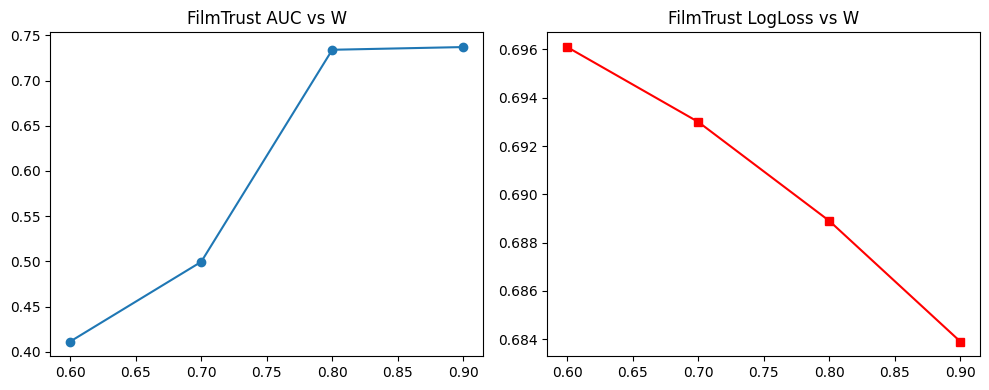

In [11]:
# ============================================================
# FilmTrust Trust Prediction Pipeline
# ASYMMETRIC SIGNED-NETWORK MODEL
# ============================================================

import os
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import ttest_rel, wilcoxon, f_oneway

# ============================================================
# CONFIG
# ============================================================
# Paths updated based on your file structure
TRUST_PATH = "filmtrust_data/trust.txt" 
OUTPUT_DIR = "outputs_filmtrust"
os.makedirs(OUTPUT_DIR, exist_ok=True)

W_VALUES = [0.6, 0.7, 0.8, 0.9]
EPS = 1e-15
PREC = 4  

# ============================================================
# 1. LOAD & NEGATIVE SAMPLING (FilmTrust specific)
# ============================================================

def load_and_prepare_data(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file at {path}")

    # Load positive trust links
    df_pos = pd.read_csv(path, sep=r"\s+", header=None, names=["u", "v", "label"])
    df_pos['label'] = 1
    
    # Generate Negative Samples (Pseudo-distrust)
    # Necessary because FilmTrust trust.txt only contains positive links
    all_nodes = list(set(df_pos['u']).union(set(df_pos['v'])))
    existing_edges = set(zip(df_pos['u'], df_pos['v']))
    neg_samples = []
    
    print(f"Sampling negative edges...")
    while len(neg_samples) < len(df_pos):
        u, v = random.sample(all_nodes, 2)
        if (u, v) not in existing_edges:
            neg_samples.append({'u': u, 'v': v, 'label': -1})
            existing_edges.add((u, v))
            
    df_neg = pd.DataFrame(neg_samples)
    return pd.concat([df_pos, df_neg], ignore_index=True)

df = load_and_prepare_data(TRUST_PATH)
y = (df.label == 1).astype(int).values

print(f"[OK] Loaded FilmTrust | edges = {len(df)} (Balanced Pos/Neg)")

# ============================================================
# 2. BUILD GRAPH
# ============================================================
G = nx.DiGraph()
# Only build graph from positive links to calculate structural features
G.add_edges_from(df[df.label == 1][["u", "v"]].itertuples(index=False, name=None))
UG = G.to_undirected()

# ============================================================
# 3. FEATURE EXTRACTION
# ============================================================
rows = []
for _, r in df.iterrows():
    # Node features (handling potential missing nodes in the graph)
    u_in = G.in_degree(r.u) if G.has_node(r.u) else 0
    u_out = G.out_degree(r.u) if G.has_node(r.u) else 0
    v_in = G.in_degree(r.v) if G.has_node(r.v) else 0
    v_out = G.out_degree(r.v) if G.has_node(r.v) else 0

    # Link features
    cn = len(list(nx.common_neighbors(UG, r.u, r.v))) if (UG.has_node(r.u) and UG.has_node(r.v)) else 0
    
    try:
        jaccard = next(nx.jaccard_coefficient(UG, [(r.u, r.v)]))[2]
        adamic = next(nx.adamic_adar_index(UG, [(r.u, r.v)]))[2]
    except:
        jaccard, adamic = 0, 0
        
    pa = (G.degree(r.u) if G.has_node(r.u) else 0) * (G.degree(r.v) if G.has_node(r.v) else 0)

    rows.append({
        "label": r.label, "u_in": u_in, "u_out": u_out, "v_in": v_in, "v_out": v_out,
        "cn": cn, "jaccard": jaccard, "adamic": adamic, "pa": pa
    })

df_feat = pd.DataFrame(rows).fillna(0)

# ============================================================
# 4. NORMALIZATION
# ============================================================
for c in ["u_in", "u_out", "v_in", "v_out"]:
    df_feat[c] = np.log1p(df_feat[c])

df_feat[["u_in","u_out","v_in","v_out"]] = StandardScaler().fit_transform(
    df_feat[["u_in","u_out","v_in","v_out"]]
)

df_feat["pa"] = np.log1p(df_feat["pa"])
df_feat[["jaccard","adamic","cn","pa"]] = MinMaxScaler().fit_transform(
    df_feat[["jaccard","adamic","cn","pa"]]
)

node_cols = ["u_in","u_out","v_in","v_out"]
link_cols = ["jaccard","adamic","pa","cn"]
X = df_feat[node_cols + link_cols]

# ============================================================
# 5. FEATURE RELIABILITY
# ============================================================
def feature_reliability(y_bin):
    auc = {c: roc_auc_score(y_bin, X[c]) for c in X.columns}
    mi  = mutual_info_classif(X, y_bin, random_state=0)
    mi  = dict(zip(X.columns, MinMaxScaler().fit_transform(mi.reshape(-1,1)).flatten()))
    return auc, mi

auc_pos, mi_pos = feature_reliability((df_feat.label == 1).astype(int))
auc_neg, mi_neg = feature_reliability((df_feat.label == -1).astype(int))

# ============================================================
# 6. ASYMMETRIC TRUST MODEL
# ============================================================
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

metrics = []
alpha_beta_rows = []
losses_by_w = {}

for w in W_VALUES:
    comp_pos = {f: w*auc_pos[f] + (1-w)*mi_pos[f] for f in X.columns}
    comp_neg = {f: w*auc_neg[f] + (1-w)*mi_neg[f] for f in X.columns}

    alpha_pos = np.array([comp_pos[f] for f in node_cols])
    beta_pos  = np.array([comp_pos[f] for f in link_cols])
    alpha_neg = np.array([comp_neg[f] for f in node_cols])
    beta_neg  = np.array([comp_neg[f] for f in link_cols])

    # Normalize weights
    for arr in [alpha_pos, beta_pos, alpha_neg, beta_neg]:
        arr /= (arr.sum() + EPS)

    S_pos = df_feat[node_cols].values @ alpha_pos + df_feat[link_cols].values @ beta_pos
    S_neg = df_feat[node_cols].values @ alpha_neg + df_feat[link_cols].values @ beta_neg

    probs = sigmoid(S_pos - S_neg)
    ll = -(y*np.log(probs+EPS) + (1-y)*np.log(1-probs+EPS))
    losses_by_w[w] = ll

    metrics.append([round(w, PREC), round(roc_auc_score(y, probs), PREC), 
                    round(average_precision_score(y, probs), PREC), round(ll.mean(), PREC)])

# ============================================================
# 7. SAVE & STATS
# ============================================================
metrics_df = pd.DataFrame(metrics, columns=["w","AUC","AP","LogLoss"])
metrics_df.to_csv(f"{OUTPUT_DIR}/metrics_asymmetric.csv", index=False)

# Visual Verification (Plots)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(metrics_df['w'], metrics_df['AUC'], marker='o', label='AUC')
plt.title('FilmTrust AUC vs W')
plt.subplot(1,2,2)
plt.plot(metrics_df['w'], metrics_df['LogLoss'], marker='s', color='red', label='LogLoss')
plt.title('FilmTrust LogLoss vs W')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/ft_performance_summary.png")

print("\n=== FILMTRUST MODEL COMPLETED SUCCESSFULLY ===")
print(metrics_df)